## Example: Pruning of encoding circuits

This examples displays how redundant parameters can be (automatically) removed from encoding circuits.

In [1]:
import numpy as np

from squlearn.encoding_circuit import (
    PrunedEncodingCircuit,
    pruning_from_QFI,
    automated_pruning,
)
from squlearn.encoding_circuit import LayeredEncodingCircuit
from squlearn.util.qfi import get_quantum_fisher
from squlearn.util.executor import Executor

Create a encoding circuit with redundant parameters.
The first two Rz rotations are redundant, since they are applied to the 0 state.
The second Ry gates are redundant, since they commutate with the Z gates and two consecutive Ry gates can be replaced by a single Ry gate with the sum of the angles.

C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


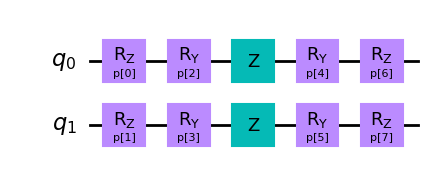

In [2]:
# Example for two qubits
nqubit = 2

# Generate and print the example pqc
pqc = LayeredEncodingCircuit.from_string("Rz(p)-Ry(p)-Z-Ry(p)-Rz(p)", nqubit, num_features=0)
pqc.draw("mpl")

Evaluate the quantum fisher matrix of the parameterized circuit for random parameters.

In [9]:
# Generate random parameters
np.random.seed(0)
param = np.random.rand(pqc.num_parameters)

# Nicer numpy output
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# Evaluate and print the Quantum Fisher Information Matrix
executor = Executor()
QFIM = get_quantum_fisher(pqc, [], param, executor)
print(QFIM)

[[ 0.     0.    -0.    -0.    -0.     0.     0.     0.   ]
 [ 0.     0.    -0.    -0.     0.     0.     0.     0.   ]
 [-0.    -0.     1.     0.    -1.    -0.    -0.    -0.   ]
 [-0.    -0.     0.     1.    -0.    -1.    -0.     0.   ]
 [-0.     0.    -1.    -0.     1.     0.     0.     0.   ]
 [ 0.     0.    -0.    -1.     0.     1.     0.     0.   ]
 [ 0.     0.    -0.    -0.     0.     0.     0.032  0.   ]
 [ 0.     0.    -0.     0.     0.     0.     0.     0.01 ]]


Calculate and print the spectrum of the Quantum Fisher Information Matrix. Zero eigenvalues indicate redundant parameters.

In [4]:
V, D = np.linalg.eig(QFIM)
print(np.sort(V))

[-0.     0.     0.     0.     0.01   0.032  2.     2.   ]


Function that computes the indices of the redundant parameters from the Quantum Fisher Information Matrix.
The algorthims follows https://doi.org/10.1103/PRXQuantum.2.040309

In [5]:
red_gate = pruning_from_QFI(QFIM)
print(np.sort(red_gate))

[0 1 4 5]


Create a new circuit in which the redundant parameters are removed from the circuit.

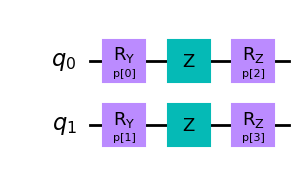

In [6]:
# Construct and print the pruned PQC
pruned_pqc = PrunedEncodingCircuit(pqc, red_gate)
pruned_pqc.draw("mpl")

In sQUlearn, there is also an automatic pruning function that removes redundant parameters from the circuit.
The resulting circuit is equivalent to the manually pruned circuit, since the Ry and Z gates commute.

Pruned parameters: [0 1 3 4]


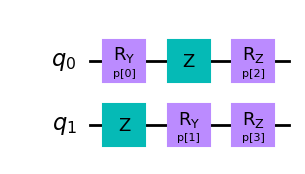

In [7]:
pruned_pqc_auto = automated_pruning(pqc, executor)
pruned_pqc_auto.draw("mpl")